In [1]:
import os
import glob
import logging
import numpy as np
import matplotlib.pyplot as plt
from neuron import h

from bmtool.singlecell import (
    Passive, CurrentClamp, ZAP, FI, Profiler, run_and_plot,
    load_allen_database_cells
)

%matplotlib inline

# Disable warnings for cleaner output
logging.disable(logging.WARNING)

--No graphics will be displayed.


In [2]:
profiler = Profiler(template_dir='.', mechanism_dir='modfiles', dt=0.05)

In [3]:
h.load_file("stdrun.hoc")

class SimpleSoma(object):
    """Single-section cell: A soma with leak, sodium, and potassium channels."""
    def __init__(self):
        self.create_sections()
        self.build_topology()
        self.build_subsets()
        self.define_geometry()
        self.define_biophysics()
    #
    def create_sections(self):
        """Create the sections of the cell."""
        # NOTE: cell=self is required to tell NEURON of this object.
        self.soma = h.Section(name='soma', cell=self)
    #
    def build_topology(self):
        """Connect the sections of the cell to build a tree."""
        # Single section - no connections needed
        pass
    #
    def define_geometry(self):
        """Set the 3D geometry of the cell."""
        self.soma.L = 500     # soma length um
        self.soma.diam = 500  # soma diameter um
        h.define_shape()      # Translate into 3D points.
    #
    def define_biophysics(self):
        """Assign the membrane properties across the cell."""
        for sec in self.all: # 'all' defined in build_subsets
            sec.cm = 1       # membrane capacitance uF/cm2
            sec.Ra = 30      # ohm-cm
        
        # Insert leak channel
        self.soma.insert('leak')  # Leak channel
        self.soma.glbar_leak = 0.0003  # S/cm2
        self.soma.el_leak = -60  # mV
        
        # Insert sodium channel
        self.soma.insert('na')  # Sodium channel
        self.soma.gnabar_na = 0.12  # S/cm2
        self.soma.nao = 79.8  # extracellular Na concentration
        
        # Insert potassium channel
        self.soma.insert('k')  # Potassium channel
        self.soma.gkbar_k = 0.036  # S/cm2
        self.soma.ki = 69.35  # intracellular K concentration
    #
    def build_subsets(self):
        """Build subset lists. For now we define 'all'."""
        self.all = h.SectionList()
        self.all.wholetree(sec=self.soma)


cell = SimpleSoma()

In [4]:
# class ReusableCurrentClamp:
#     """
#     A reusable CurrentClamp that allows parameter modifications and re-runs
#     without rebuilding the cell or the IClamp object.
    
#     This class wraps a pre-initialized cell and allows you to:
#     1. Run an initial stimulus
#     2. Modify cell parameters (e.g., soma.gnabar_na)
#     3. Reset NEURON state and re-run without rebuilding
#     4. Detect spikes based on a voltage threshold
#     """
    
#     def __init__(self, cell, inj_site=(0, 0.5), rec_site=(0, 0.5), 
#                  inj_amp=100, inj_delay=1500, inj_dur=1000, tstop=3000, threshold=-15.0):
#         """
#         Initialize ReusableCurrentClamp with a pre-built cell.
        
#         Parameters
#         ----------
#         cell : object
#             A pre-initialized cell object (e.g., SimpleSoma instance)
#         inj_site : tuple, optional
#             Injection site as (section_index, position). Default (0, 0.5) = soma midpoint
#         rec_site : tuple, optional
#             Recording site as (section_index, position). Default (0, 0.5) = soma midpoint
#         inj_amp : float, optional
#             Injection current amplitude in pA. Default 100 pA
#         inj_delay : float, optional
#             Delay before injection starts in ms. Default 1500 ms
#         inj_dur : float, optional
#             Duration of injection in ms. Default 1000 ms
#         tstop : float, optional
#             Total simulation time in ms. Default 3000 ms
#         threshold : float, optional
#             Voltage threshold (mV) for spike detection. Default -15.0 mV
#         """
#         self.cell = cell
#         self.inj_site = inj_site
#         self.rec_site = rec_site
#         self.inj_amp = inj_amp  # Store in pA
#         self.inj_delay = inj_delay
#         self.inj_dur = inj_dur
#         self.tstop = tstop
#         self.threshold = threshold
#         self.spike_times = []  # Store detected spike times
        
#         # Initialize recording vectors and IClamp
#         self._setup_experiment()
    
#     def _get_target_site(self, section_idx, position):
#         """Get target segment and section for injection/recording."""
#         all_secs = list(self.cell.all)
#         sec = all_secs[section_idx]
#         seg = sec(position)
#         return seg, sec
    
#     def _setup_experiment(self):
#         """Set up the IClamp and recording vectors."""
#         # Get injection and recording sites
#         self.inj_seg, self.inj_sec = self._get_target_site(self.inj_site[0], self.inj_site[1])
#         self.rec_seg, self.rec_sec = self._get_target_site(self.rec_site[0], self.rec_site[1])
        
#         # Create IClamp at injection site
#         self.iclamp = h.IClamp(self.inj_seg)
#         self.iclamp.amp = self.inj_amp / 1000.0  # Convert pA to nA
#         self.iclamp.delay = self.inj_delay
#         self.iclamp.dur = self.inj_dur
        
#         # Create recording vectors
#         self.t_vec = h.Vector()
#         self.v_vec = h.Vector()
#         self.t_vec.record(h._ref_t)
#         self.v_vec.record(self.rec_seg._ref_v)
    
#     def _detect_spikes(self, t, v):
#         """
#         Detect spikes by finding voltage crossings above threshold.
        
#         Parameters
#         ----------
#         t : list
#             Time values (ms)
#         v : list
#             Voltage values (mV)
            
#         Returns
#         -------
#         spike_times : list
#             Times (ms) when spikes were detected
#         """
#         spike_times = []
#         above_threshold = False
        
#         for i in range(len(v) - 1):
#             # Check if voltage crosses threshold upward
#             if v[i] < self.threshold and v[i + 1] >= self.threshold:
#                 if not above_threshold:  # Only count once per spike
#                     spike_times.append(t[i])
#                     above_threshold = True
#             # Check if voltage crosses threshold downward (spike repolarizing)
#             elif v[i] >= self.threshold and v[i + 1] < self.threshold:
#                 above_threshold = False
        
#         return spike_times
    
#     def run(self):
#         """
#         Run the simulation with current parameters.
        
#         Returns
#         -------
#         t : list
#             Time values (ms)
#         v : list
#             Voltage values (mV)
#         """
#         # Initialize and run simulation
#         h.finitialize(h.v_init)
#         h.continuerun(self.tstop)
        
#         # Convert NEURON vectors to Python lists
#         t = list(self.t_vec)
#         v = list(self.v_vec)
        
#         # Detect spikes
#         self.spike_times = self._detect_spikes(t, v)
        
#         return t, v
    
#     def reset_state(self):
#         """
#         Reset NEURON's internal state without rebuilding the cell or IClamp.
#         Call this before re-running after modifying cell parameters.
#         """
#         # Re-initialize voltage-gated state variables to rest state
#         h.stdinit()
#         # Clear recording vectors
#         self.t_vec.clear()
#         self.v_vec.clear()
#         # Clear spike times
#         self.spike_times = []
    
#     def modify_iclamp(self, **kwargs):
#         """
#         Modify IClamp parameters on-the-fly.
        
#         Parameters
#         ----------
#         amp : float, optional
#             New amplitude in pA
#         delay : float, optional
#             New delay in ms
#         dur : float, optional
#             New duration in ms
#         """
#         if 'amp' in kwargs:
#             self.iclamp.amp = kwargs['amp'] / 1000.0  # Convert pA to nA
#         if 'delay' in kwargs:
#             self.iclamp.delay = kwargs['delay']
#         if 'dur' in kwargs:
#             self.iclamp.dur = kwargs['dur']
    
#     def modify_tstop(self, tstop):
#         """Modify total simulation time."""
#         self.tstop = tstop
    
#     def modify_threshold(self, threshold):
#         """Modify spike detection threshold."""
#         self.threshold = threshold

In [5]:
analysis_settings = {
    'CurrentClamp': {
        'celsius': 34.0,
        'kwargs': {
            'inj_amp': 100,   
            'inj_delay': 1500.0,
            'inj_dur': 1000.0,
            'tstop': 3000.0,
            'threshold': -15.0
        }
    },
}

Injection location: <__main__.SimpleSoma object at 0x7fc93fa5ba30>.soma(0.5)
Recording: <__main__.SimpleSoma object at 0x7fc93fa5ba30>.soma(0.5)._ref_v
Current clamp simulation running...

Number of spikes: 0



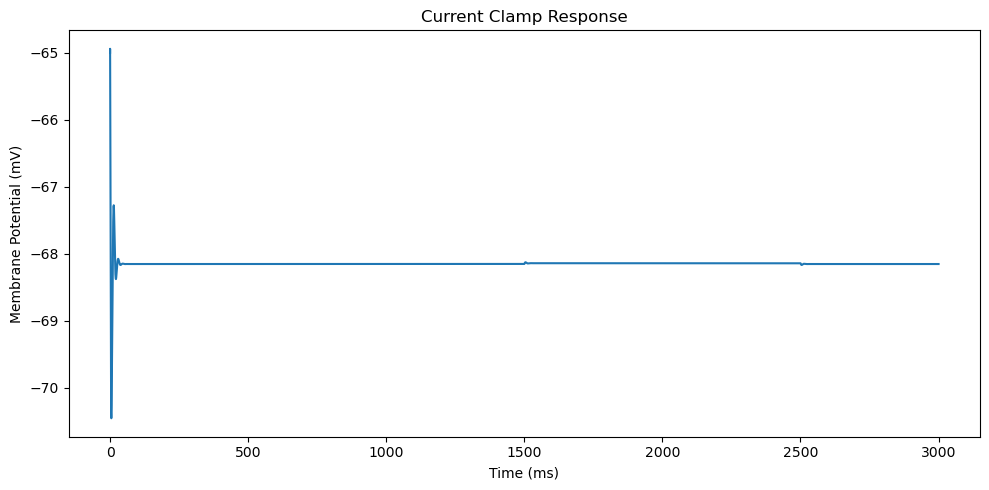

In [6]:
proc_settings = analysis_settings['CurrentClamp']
h.celsius = proc_settings['celsius']

# Create ReusableCurrentClamp instance
sim_cc = CurrentClamp(cell, **proc_settings['kwargs'])

# First run
t1, v1 = sim_cc.run()

plt.figure(figsize=(10, 5))
plt.plot(t1, v1)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Current Clamp Response')
plt.tight_layout()
plt.show()

In [7]:
# Modify cell parameter
cell.soma.gnabar_na = 0.22  # S/cm2

Current clamp simulation running...

Number of spikes: 179



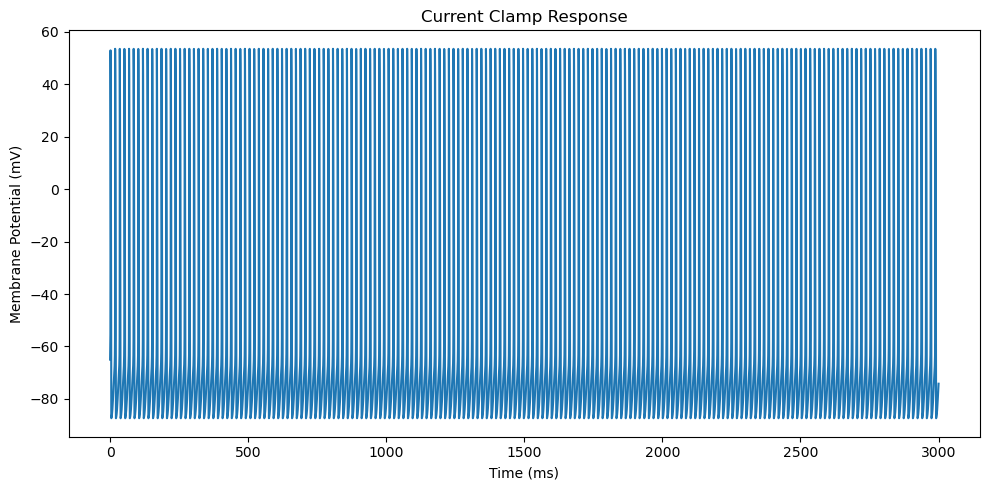

In [8]:
# Reset NEURON state and re-run with modified parameter (no cell rebuild!)
sim_cc.reset_state()
t2, v2 = sim_cc.run()

plt.figure(figsize=(10, 5))
plt.plot(t2, v2)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Current Clamp Response')
plt.tight_layout()
plt.show()

Current clamp simulation running...

Number of spikes: 0

Iteration 0: gnabar_na = 0.120, spikes = 0
Current clamp simulation running...

Number of spikes: 0

Iteration 1: gnabar_na = 0.130, spikes = 0
Current clamp simulation running...

Number of spikes: 0

Iteration 2: gnabar_na = 0.140, spikes = 0
Current clamp simulation running...

Number of spikes: 0

Iteration 3: gnabar_na = 0.150, spikes = 0
Current clamp simulation running...

Number of spikes: 0

Iteration 4: gnabar_na = 0.160, spikes = 0
Current clamp simulation running...

Number of spikes: 0

Iteration 5: gnabar_na = 0.170, spikes = 0
Current clamp simulation running...

Number of spikes: 172

Iteration 6: gnabar_na = 0.180, spikes = 172
Target achieved with gnabar_na = 0.180


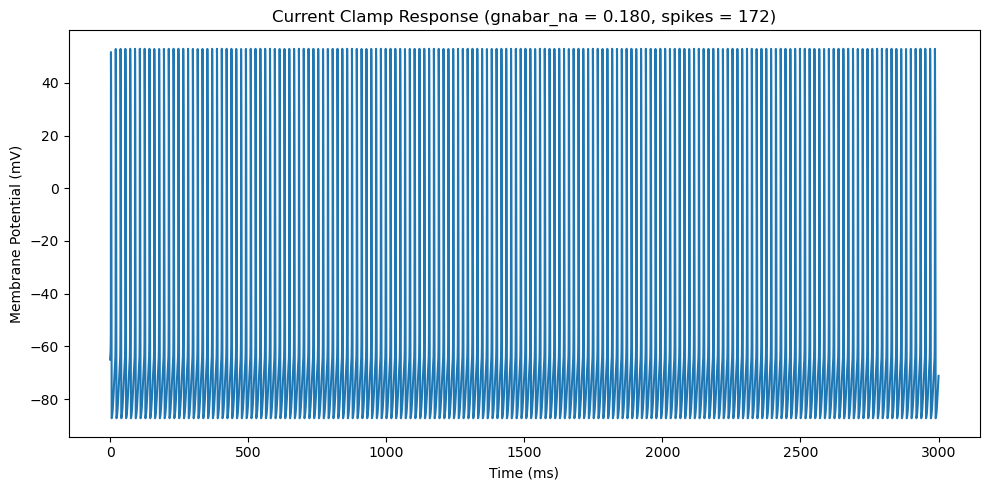

In [11]:
# Automatically adjust gnabar_na to achieve target number of spikes
target_spikes = 5  # Set desired number of spikes
gnabar_na_start = 0.12  # Starting value
gnabar_na_step = 0.01  # Increment step
max_iterations = 100  # Safety limit

gnabar_na = gnabar_na_start
iteration = 0

# Clear any previous spike detections
sim_cc.nspks = 0

while sim_cc.nspks < target_spikes and iteration < max_iterations:
    cell.soma.gnabar_na = gnabar_na
    sim_cc.reset_state()
    t, v = sim_cc.run()
    current_spikes = sim_cc.nspks
    print(f"Iteration {iteration}: gnabar_na = {gnabar_na:.3f}, spikes = {current_spikes}")
    if current_spikes >= target_spikes:
        break
    gnabar_na += gnabar_na_step
    iteration += 1

if iteration >= max_iterations:
    print("Warning: Maximum iterations reached without achieving target spikes")
else:
    print(f"Target achieved with gnabar_na = {gnabar_na:.3f}")

# Plot the final result
plt.figure(figsize=(10, 5))
plt.plot(t, v)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title(f'Current Clamp Response (gnabar_na = {gnabar_na:.3f}, spikes = {sim_cc.nspks})')
plt.tight_layout()
plt.show()